LOAD THE DATASET

In [1]:
# Install missing packages (if needed)
!pip install lime shap matplotlib seaborn pandas scikit-learn openpyxl

# Importing libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_auc_score, classification_report, cohen_kappa_score
)
import lime.lime_tabular
import shap
import matplotlib.pyplot as plt
import seaborn as sns
import time

# # For visualizing SHAP
# shap.initjs()

# # Load the dataset
# df = pd.read_excel('Accident_Dataset_Preprocessing.xlsx', sheet_name='Accident')

# # Display the first few rows
# df.head()


     ---------------------------------------- 0.0/275.7 kB ? eta -:--:--
     ---- -------------------------------- 30.7/275.7 kB 435.7 kB/s eta 0:00:01
     ---------------- --------------------- 122.9/275.7 kB 1.2 MB/s eta 0:00:01
     -------------------------------------- 275.7/275.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/456.2 kB ? eta -:--:--
   ----------------- ---------------------- 204.8/456.2 kB 6.3 MB/s eta 0:00:01
   ---------------------------------------  450.6/456.2 kB 7.1 MB/s eta 0:00:01
   ---------------------------------------  450.6/456.2 kB 7.1 MB/s eta 0:00:01
   ---------------------------------------  450.6/456.2 kB 7.1 MB/s eta 0:00:01
   ---------------------------------------  450.6/456.2 kB 7.1 MB/s eta 0:00:01
   ---------------------------------------  450.6/456.2 kB 7.1 MB/s eta 0:00:01
   -------------------------------

1. DATA PREPROCESSING

In [4]:
# # 1. Drop columns with more than 50% missing values
threshold = 0.5 * len(df)
df = df.dropna(thresh=threshold, axis=1)

# # 2. Drop rows where critical values are missing (target or key columns)
df = df.dropna(subset=['Accident_severity', 'Time'])

# # 3. Impute categorical features with the most frequent value (mode)
for column in df.select_dtypes(include='object').columns:
    df[column].fillna(df[column].mode()[0], inplace=True)

# # 4. Impute numerical features with the median value
for column in df.select_dtypes(include=['int64', 'float64']).columns:
    df[column].fillna(df[column].median(), inplace=True)

# # Verify if all missing values are handled
print(df.isnull().sum())

# # Save the preprocessed dataset to an Excel file
df.to_excel("C:\\Users\\User\\Downloads\\Accident_Dataset_After_Preprocessing.xlsx", index=False)
print("Preprocessed dataset saved successfully.")


NameError: name 'df' is not defined

For the above steps:

Step 1: Drop columns where more than 50% of values are missing to avoid introducing noise.

Step 2: Drop rows where target values (Accident_severity) or critical features are missing since they are essential for prediction.

Step 3: For categorical variables, use mode (most frequent value) to fill missing data.

Step 4: For numerical variables, use the median to avoid the effect of outliers.


NOW SAVE THE PREPROCESSED DATASET TO A NEW EXCEL

In [23]:
# # Save the preprocessed dataset to an Excel file
df.to_excel('Accident_Dataset_After_Preprocessing.xlsx', index=False)

print("Preprocessed dataset saved as 'Accident_Dataset_After_Preprocessing.xlsx'")


Preprocessed dataset saved as 'Accident_Dataset_After_Preprocessing.xlsx'


LOAD PREPROCESSED DATASET

In [29]:
# Load the preprocessed dataset
df = pd.read_excel("C:\\Users\\User\\Downloads\\Accident_Dataset_After_Preprocessing.xlsx")

# Display the first few rows to confirm
df.head()


Time Day_of_week Age_band_of_driver Sex_of_driver   Educational_level  \
0  17:02:00      Monday              18-30          Male   Above high school   
1  17:02:00      Monday              31-50          Male  Junior high school   
2  17:02:00      Monday              18-30          Male  Junior high school   
3  01:06:00      Sunday              18-30          Male  Junior high school   
4  01:06:00      Sunday              18-30          Male  Junior high school   

  Vehicle_driver_relation Driving_experience      Type_of_vehicle  \
0                Employee              1-2yr           Automobile   
1                Employee         Above 10yr  Public (> 45 seats)   
2                Employee              1-2yr      Lorry (41?100Q)   
3                Employee             5-10yr  Public (> 45 seats)   
4                Employee              2-5yr           Automobile   

  Owner_of_vehicle Service_year_of_vehicle  ... Vehicle_movement  \
0            Owner              Above 10yr  ...   Going straight   
1            Owner                 5-10yrs  ...   Going straight   
2            Owner                 Unknown  ...   Going straight   
3     Governmental                 Unknown  ...   Going straight   
4            Owner                 5-10yrs  ...   Going straight   

    Casualty_class Sex_of_casualty Age_band_of_casualty Casualty_severity  \
0               na              na                   na                na   
1               na              na                   na                na   
2  Driver or rider            Male                31-50                 3   
3       Pedestrian          Female                18-30                 3   
4               na              na                   na                na   

  Work_of_casuality Fitness_of_casuality Pedestrian_movement  \
0            Driver               Normal    Not a Pedestrian   
1            Driver               Normal    Not a Pedestrian   
2            Driver               Normal    Not a Pedestrian   
3            Driver               Normal    Not a Pedestrian   
4            Driver               Normal    Not a Pedestrian   

            Cause_of_accident Accident_severity  
0             Moving Backward     Slight Injury  
1                  Overtaking     Slight Injury  
2   Changing lane to the left    Serious Injury  
3  Changing lane to the right     Slight Injury  
4                  Overtaking     Slight Injury  

[5 rows x 32 columns]

MODEL BUILDING AND EVALUATION

In [38]:
# Encode categorical variables
label_encoders = {}
for column in df.select_dtypes(include='object').columns:
    le = LabelEncoder()
    df[column] = le.fit_transform(df[column])
    label_encoders[column] = le

# Separate features and target
X = df.drop('Accident_severity', axis=1)
y = df['Accident_severity']

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the Decision Tree model
start_time = time.time()
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
dt_time = time.time() - start_time

# Train the Logistic Regression model
start_time = time.time()
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train, y_train)
lr_time = time.time() - start_time

# Define a function to evaluate models
def evaluate_model(model, X_test, y_test, model_name, train_time):
    y_pred = model.predict(X_test)
    print(f"Performance Metrics for {model_name}:")
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    kappa = cohen_kappa_score(y_test, y_pred)
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Cohen's Kappa:", kappa)
    print("Training Time:", train_time, "seconds")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    # Replace any None values with 0.0 for plotting
    return [metric if metric is not None else 0.0 for metric in [accuracy, precision, recall, f1, kappa]]

# Evaluate both models and store the results
decision_tree_metrics = evaluate_model(dt_model, X_test, y_test, "Decision Tree", dt_time)
logistic_regression_metrics = evaluate_model(lr_model, X_test, y_test, "Logistic Regression", lr_time)




Performance Metrics for Decision Tree:
Accuracy: 0.7593344155844156
Precision: 0.7715719456537042
Recall: 0.7593344155844156
F1 Score: 0.7651859738258828
Cohen's Kappa: 0.17187783379883215
Training Time: 0.14901423454284668 seconds

Classification Report:
               precision    recall  f1-score   support

           0       0.29      0.32      0.31        37
           1       0.26      0.30      0.28       363
           2       0.87      0.85      0.86      2064

    accuracy                           0.76      2464
   macro avg       0.48      0.49      0.48      2464
weighted avg       0.77      0.76      0.77      2464

Performance Metrics for Logistic Regression:
Accuracy: 0.8376623376623377
Precision: 0.7016781919379322
Recall: 0.8376623376623377
F1 Score: 0.7636638979395164
Cohen's Kappa: 0.0
Training Time: 0.08402204513549805 seconds

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00        37
      

c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\User\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


VISUALIZATIONS

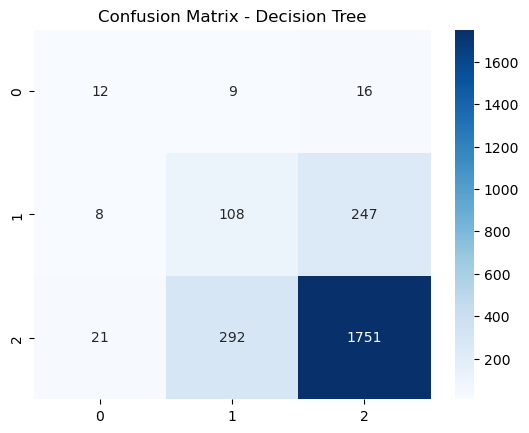

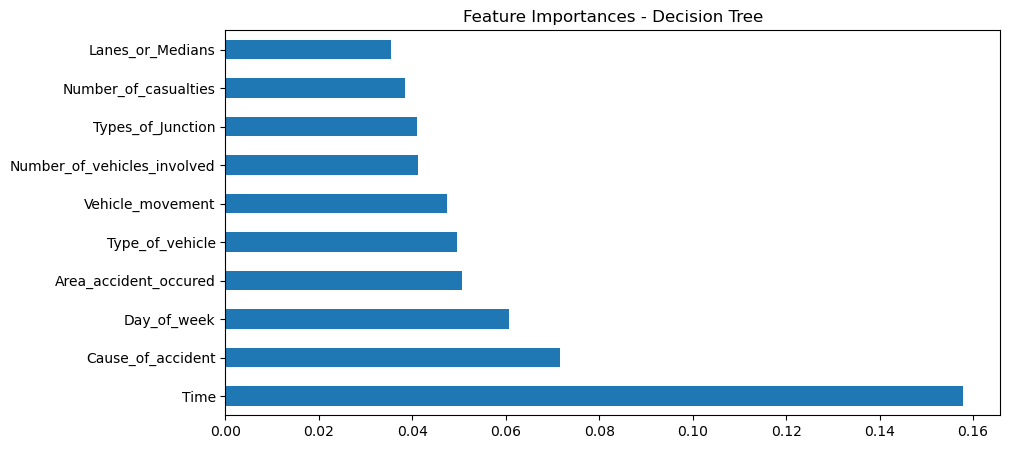

In [31]:
# Confusion Matrix for Decision Tree
dt_conf_matrix = confusion_matrix(y_test, dt_model.predict(X_test))
sns.heatmap(dt_conf_matrix, annot=True, cmap='Blues', fmt='d')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

# Feature Importance for Decision Tree
plt.figure(figsize=(10, 5))
feature_importances = pd.Series(dt_model.feature_importances_, index=X.columns)
feature_importances.nlargest(10).plot(kind='barh')
plt.title('Feature Importances - Decision Tree')
plt.show()


XAI TECHNIQUES - LIME AND SHAP

LIME

In [32]:
# Initialize LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train, feature_names=X.columns, class_names=['Slight', 'Serious'], mode='classification'
)

# Explain a sample prediction with LIME (Decision Tree)
i = 5  # Example index from test set
exp = explainer.explain_instance(X_test[i], dt_model.predict_proba)
exp.show_in_notebook()


SHAP

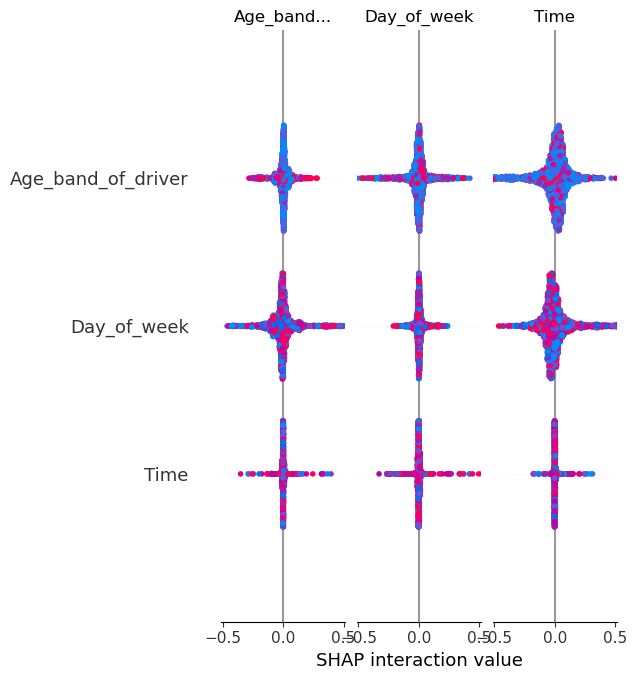

In [9]:
# Initialize SHAP TreeExplainer
shap_explainer = shap.TreeExplainer(dt_model)
shap_values = shap_explainer.shap_values(X_test)

# Plot SHAP summary
shap.summary_plot(shap_values, X_test, feature_names=X.columns)


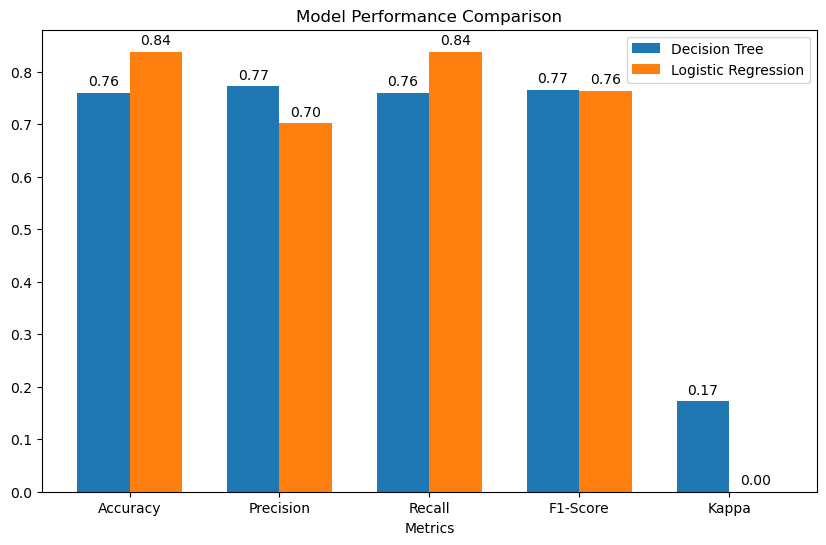

In [39]:
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'Kappa']

# Create bar chart
x = np.arange(len(metrics)) 
width = 0.35 

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width/2, decision_tree_metrics, width, label='Decision Tree')
rects2 = ax.bar(x + width/2, logistic_regression_metrics, width, label='Logistic Regression')

# Add  labels, title, and axes ticks
ax.set_xlabel('Metrics')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Attach a text label above each bar in rects, displaying its height
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3), 
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

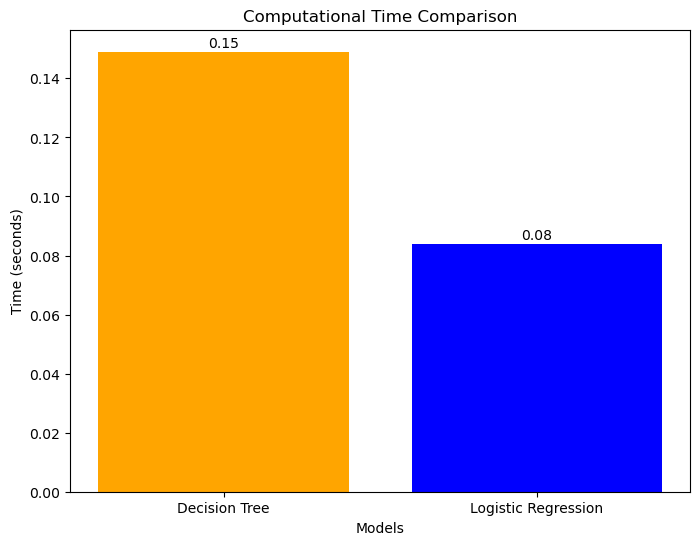

In [47]:
# Computational time data (in seconds)
models = ['Decision Tree', 'Logistic Regression']
computation_time = [dt_time, lr_time]

# Create bar chart
fig, ax = plt.subplots(figsize=(8, 6))
ax.bar(models, computation_time, color=['orange', 'blue'])

# Add text for labels, title, and axes ticks
ax.set_xlabel('Models')
ax.set_ylabel('Time (seconds)')
ax.set_title('Computational Time Comparison')

# Add value labels on bars 
for i, v in enumerate(computation_time):
    ax.text(i, v + 0.0005, f"{v:.2f}", ha='center', va='bottom')  

plt.show()



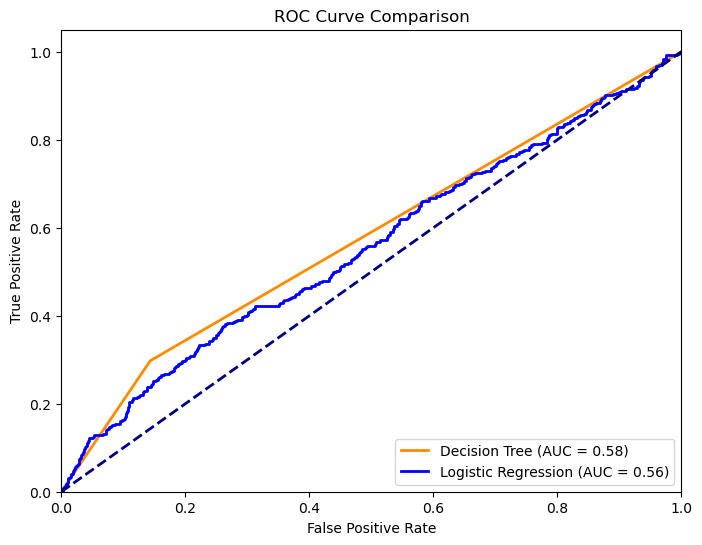

In [27]:
from sklearn.metrics import roc_curve, auc

# Predict probabilities for both models
y_prob_dt = dt_model.predict_proba(X_test)
y_prob_lr = lr_model.predict_proba(X_test)

# Compute ROC curve and ROC area for both models (using one class as an example)
fpr_dt, tpr_dt, _ = roc_curve(y_test, y_prob_dt[:, 1], pos_label=1)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr[:, 1], pos_label=1)

# Compute AUC
roc_auc_dt = auc(fpr_dt, tpr_dt)
roc_auc_lr = auc(fpr_lr, tpr_lr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_dt, tpr_dt, color='darkorange', lw=2, label=f'Decision Tree (AUC = {roc_auc_dt:.2f})')
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend(loc='lower right')
plt.show()
